In [63]:
import IPython.display as ipd
import os
import pandas as pd
import numpy as np
import librosa
import glob 
import librosa.display
import random
import matplotlib.pyplot as plt

from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

from sklearn import metrics
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from datetime import datetime

In [2]:
#pip install Keras

In [21]:
def extract_features(files):
    
    # Абсолютный путь файла из папки со всеми данными
    file_name = os.path.join(os.path.abspath('voice')+'/'+str(files.file))

    # возвращает звуковой временной ряд в качестве массива numpy 
    # с частотой дискретизации по умолчанию 22 кГц
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 

    # Генерация Мел-частотных кепстральных коэффициентов 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)

    # Используя короткое преобразование Фурье (STFT), вычисляем хронограмму(Цветность)
    stft = np.abs(librosa.stft(X))
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)

    # Строим мел-спектрограмму
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)

    # Вычисляем спектральный контраст
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)

    # Вычисляем тональные особенности центроида
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
        
    label = files.label

    return mfccs, chroma, mel, contrast, tonnetz, label

In [3]:
# Извлекаем список файлов
filelist = os.listdir('male') 
# Создаем датафрейм и наполняем его данными из filelist
df_male = pd.DataFrame(filelist)

In [4]:
# Добавляем метку "1" для диктора-мужчины
df_male['label']='1'

# Даем имя столбцу "file"
df_male = df_male.rename(columns={0:'file'})

In [6]:
df_male.head()

,file,label
0,1034-121119-0000.flac,1
1,1034-121119-0001.flac,1
2,1034-121119-0002.flac,1
3,1034-121119-0003.flac,1
4,1034-121119-0004.flac,1


In [7]:
# Извлекаем список файлов
filelist = os.listdir('female') 
# Создаем датафрейм и наполняем его данными из filelist
df_female = pd.DataFrame(filelist)

In [8]:
# Добавляем метку "0" для диктора-женщины
df_female['label']='0'

# Даем имя столбцу "file"
df_female = df_female.rename(columns={0:'file'})

In [10]:
df_female.head()

,file,label
0,103-1240-0000.flac,0
1,103-1240-0001.flac,0
2,103-1240-0002.flac,0
3,103-1240-0003.flac,0
4,103-1240-0004.flac,0


In [12]:
# Объединяем оба датафрема
df = pd.concat([df_female, df_male], ignore_index=True)

In [13]:
df.head()

,file,label
0,103-1240-0000.flac,0
1,103-1240-0001.flac,0
2,103-1240-0002.flac,0
3,103-1240-0003.flac,0
4,103-1240-0004.flac,0


In [14]:
df = df.sample(frac=1).reset_index(drop=True)

In [50]:
# Разделяем данные на тренировочный набор (составляет 70% от общих данных)

df_train = df[:19978]

In [51]:
df_train['label'].value_counts(normalize=True)

0    0.543147
1    0.456853
Name: label, dtype: float64

In [52]:
# Разделяем данные на проверочный набор (составляет 20% от общих данных)

df_validation = df[19978:25686]

In [53]:
df_validation['label'].value_counts(normalize=True)

0    0.546076
1    0.453924
Name: label, dtype: float64

In [54]:
# Разделяем данные на проверочный набор (составляет 10% от общих данных)

df_test = df[25686:28539]

In [55]:
df_test['label'].value_counts(normalize=True)

0    0.539082
1    0.460918
Name: label, dtype: float64

In [23]:
# Применяем функцию извлечения фичей на сырых данных из датасета
features_label = df.apply(extract_features, axis=1)

D:\Users\Dobro\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=955
  warnings.warn(
D:\Users\Dobro\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=802
  warnings.warn(
D:\Users\Dobro\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=736
  warnings.warn(
D:\Users\Dobro\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=740
  warnings.warn(
D:\Users\Dobro\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=841
  warnings.warn(
D:\Users\Dobro\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=808
  warnings.warn(
D:\Users\Dobro\anaconda3\lib\site-packages\librosa\c

D:\Users\Dobro\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=758
  warnings.warn(
D:\Users\Dobro\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=988
  warnings.warn(
D:\Users\Dobro\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=755
  warnings.warn(
D:\Users\Dobro\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=948
  warnings.warn(
D:\Users\Dobro\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=851
  warnings.warn(
D:\Users\Dobro\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=829
  warnings.warn(
D:\Users\Dobro\anaconda3\lib\site-packages\librosa\c

D:\Users\Dobro\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=690
  warnings.warn(
D:\Users\Dobro\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=824
  warnings.warn(
D:\Users\Dobro\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=731
  warnings.warn(
D:\Users\Dobro\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=822
  warnings.warn(
D:\Users\Dobro\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=903
  warnings.warn(
D:\Users\Dobro\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=688
  warnings.warn(
D:\Users\Dobro\anaconda3\lib\site-packages\librosa\c

D:\Users\Dobro\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=784
  warnings.warn(
D:\Users\Dobro\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=908
  warnings.warn(
D:\Users\Dobro\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=898
  warnings.warn(
D:\Users\Dobro\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=646
  warnings.warn(
D:\Users\Dobro\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=660
  warnings.warn(
D:\Users\Dobro\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=683
  warnings.warn(
D:\Users\Dobro\anaconda3\lib\site-packages\librosa\c

In [25]:
features_label

0        ([-322.77884, 121.14731, -1.3028635, 39.232086...
1        ([-345.90323, 83.374695, -67.35545, 59.75551, ...
2        ([-316.50705, 111.82954, -61.97776, 54.39417, ...
3        ([-377.3722, 115.58217, -23.183352, 42.084183,...
4        ([-322.7253, 122.72636, -32.28791, 24.694458, ...
                               ...                        
28534    ([-325.98065, 143.64465, -6.247757, 16.577755,...
28535    ([-351.18234, 105.61831, -31.887411, 36.27641,...
28536    ([-342.276, 137.85878, 1.3029813, 38.62174, 0....
28537    ([-353.3031, 96.5085, -10.088492, 37.451416, -...
28538    ([-349.79114, 110.58875, -27.925947, 36.590755...
Length: 28539, dtype: object

In [26]:
# Сохраняем вектор извлеченных фичей

# np.save('features_label', features_label)

# Загружаем вектор извлеченных фичей

# features_label = np.load('features_label.npy', allow_pickle=True)

In [28]:
# Создаем пустой список, где объединяем все извлеченный фичи в одну.

features = []
for i in range(0, len(features_label)):
    features.append(np.concatenate((features_label[i][0], features_label[i][1], 
                features_label[i][2], features_label[i][3],
                features_label[i][4]), axis=0))

In [29]:
len(features)

28539

In [30]:
# Создаем пустой список, в который добавляем все идентификаторы дикторов, 
# зная, что id диктора определяется до первого символа "-"
speaker = []
for i in range(0, len(df)):
    speaker.append(df['file'][i].split('-')[0])

In [31]:
# Cоздаем список дикторов, наполняя его.
df['speaker'] = speaker

In [32]:
df.head()

,file,label,speaker
0,5778-54535-0009.flac,0,5778
1,1737-148989-0003.flac,0,1737
2,298-126791-0060.flac,0,298
3,7059-77900-0009.flac,0,7059
4,6272-70191-0009.flac,0,6272


In [33]:
# Проверяем сколько различных дикторов в датасете
df['speaker'].nunique()

251

In [34]:
# Устанавливаем метки, равные списку дикторов
labels = speaker

In [36]:
# Checking the size of labels and making sure it matches the size of features
len(labels)

28539

In [37]:
# Проверяем наличие сбалансированных классов для всех данных
np.unique(labels, return_counts=True)

(array(['103', '1034', '1040', '1069', '1081', '1088', '1098', '1116',
        '118', '1183', '1235', '1246', '125', '1263', '1334', '1355',
        '1363', '1447', '1455', '150', '1502', '1553', '1578', '1594',
        '1624', '163', '1723', '1737', '1743', '1841', '1867', '1898',
        '19', '1926', '196', '1963', '1970', '198', '1992', '200', '2002',
        '2007', '201', '2092', '211', '2136', '2159', '2182', '2196',
        '226', '2289', '229', '233', '2384', '2391', '2416', '2436', '248',
        '250', '2514', '2518', '254', '26', '2691', '27', '2764', '2817',
        '2836', '2843', '289', '2893', '2910', '2911', '2952', '298',
        '2989', '302', '307', '311', '3112', '3168', '32', '3214', '322',
        '3235', '3240', '3242', '3259', '328', '332', '3374', '3436',
        '3440', '3486', '3526', '3607', '3664', '3699', '3723', '374',
        '3807', '3830', '3857', '3879', '39', '3947', '3982', '3983', '40',
        '4014', '4018', '403', '405', '4051', '4088', '412', 

In [38]:
X = np.array(features)
y = np.array(labels)

In [40]:
# Hot encoding y
lb = LabelEncoder()
y = to_categorical(lb.fit_transform(y))

In [41]:
X.shape
y.shape

(28539, 193)

In [56]:
# Выбираем тренировочный набор данных (70%)
# Выбираем проверочный набор данных (20%)
# Выбираем тестовый набор данных (10%) 

# This is analogous to a train test split but we add a validation split and we are making
# we do not shuffle anything since we are dealing with several time series, we already 
# checked before that we have balanced classes (analogous to stratify)

X_train = X[:19978]
y_train = y[:19978]

X_val = X[19978:25686]
y_val = y[19978:25686]

X_test = X[25686:]
y_test = y[25686:]

In [57]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)
X_test = ss.transform(X_test)

In [60]:
# Построим простую полносвязную сеть с ранней остановкой с softmax для категориальной классификации
# Мы имеем 251 класс

model = Sequential()

model.add(Dense(193, input_shape=(193,), activation = 'relu'))
model.add(Dropout(0.1))

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))  

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))    

model.add(Dense(251, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [61]:
history = model.fit(X_train, y_train, batch_size=256, epochs=100, 
                    validation_data=(X_val, y_val))

Epoch 1/100
79/79 [==============================] - 12s 23ms/step - loss: 5.3733 - accuracy: 0.0225 - val_loss: 3.5053 - val_accuracy: 0.3712
Epoch 2/100
79/79 [==============================] - 1s 9ms/step - loss: 3.5812 - accuracy: 0.2036 - val_loss: 1.4474 - val_accuracy: 0.7798
Epoch 3/100
79/79 [==============================] - 1s 9ms/step - loss: 2.2039 - accuracy: 0.4407 - val_loss: 0.7149 - val_accuracy: 0.8854
Epoch 4/100
79/79 [==============================] - 1s 9ms/step - loss: 1.5471 - accuracy: 0.5796 - val_loss: 0.4255 - val_accuracy: 0.9334
Epoch 5/100
79/79 [==============================] - 1s 9ms/step - loss: 1.1462 - accuracy: 0.6854 - val_loss: 0.2803 - val_accuracy: 0.9511
Epoch 6/100
79/79 [==============================] - 1s 9ms/step - loss: 0.9100 - accuracy: 0.7426 - val_loss: 0.2003 - val_accuracy: 0.9650
Epoch 7/100
79/79 [==============================] - 1s 9ms/step - loss: 0.7553 - accuracy: 0.7806 - val_loss: 0.1513 - val_accuracy: 0.9718
Epoch 8/100

Epoch 59/100
79/79 [==============================] - 1s 9ms/step - loss: 0.1094 - accuracy: 0.9629 - val_loss: 0.0267 - val_accuracy: 0.9939
Epoch 60/100
79/79 [==============================] - 1s 9ms/step - loss: 0.1147 - accuracy: 0.9650 - val_loss: 0.0236 - val_accuracy: 0.9935
Epoch 61/100
79/79 [==============================] - 1s 9ms/step - loss: 0.1034 - accuracy: 0.9660 - val_loss: 0.0254 - val_accuracy: 0.9937
Epoch 62/100
79/79 [==============================] - 1s 9ms/step - loss: 0.1101 - accuracy: 0.9670 - val_loss: 0.0231 - val_accuracy: 0.9946
Epoch 63/100
79/79 [==============================] - 1s 9ms/step - loss: 0.0986 - accuracy: 0.9682 - val_loss: 0.0252 - val_accuracy: 0.9933
Epoch 64/100
79/79 [==============================] - 1s 9ms/step - loss: 0.1080 - accuracy: 0.9643 - val_loss: 0.0220 - val_accuracy: 0.9947
Epoch 65/100
79/79 [==============================] - 1s 9ms/step - loss: 0.1033 - accuracy: 0.9701 - val_loss: 0.0231 - val_accuracy: 0.9942
Epoch 

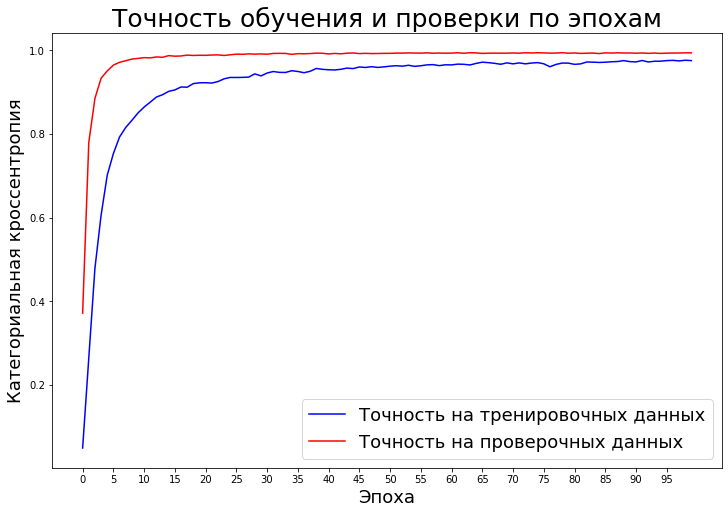

In [73]:
# Проверка точности тренировочных данных и точность проверки за эпохи.
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(12, 8))

plt.plot(train_accuracy, label='Точность на тренировочных данных', color='blue')
plt.plot(val_accuracy, label='Точность на проверочных данных', color='red')

plt.title('Точность обучения и проверки по эпохам', fontsize = 25)
plt.xlabel('Эпоха', fontsize = 18)
plt.ylabel('Категориальная кроссентропия', fontsize = 18)
plt.xticks(range(0,100,5), range(0,100,5))

plt.legend(fontsize = 18);

In [65]:
# Получаем прогнозы на основе тестовых данных
preds = model.predict_classes(X_test)

D:\Users\Dobro\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [66]:
# Преобразуем прогнозы обратно в идентификаторы выступающих
preds = lb.inverse_transform(preds)

In [67]:
# Разделяем датафрейм на тестовый набор данных
df_test = df[25686:]

In [68]:
# Создаем столбец "preds", и устанавливаем его равным прогнозам
df_test['preds'] = preds

<ipython-input-68-60f31bf082ef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['preds'] = preds


In [69]:
# Проверяем прогнозы на тестовом наборе данных
df_test

,file,label,speaker,preds
25686,2817-142380-0036.flac,0,2817,2817
25687,6880-216547-0067.flac,1,6880,6880
25688,5514-19193-0006.flac,0,5514,5514
25689,8419-293469-0024.flac,1,8419,8419
25690,2911-15084-0005.flac,1,2911,2911
...,...,...,...,...
28534,229-130880-0076.flac,1,229,229
28535,4362-15663-0009.flac,0,4362,4362
28536,6181-216552-0038.flac,1,6181,6181
28537,8465-246943-0024.flac,0,8465,8465


In [70]:
# Проверяем, сколько дикторов мы определили неверно.
df_test[df_test['speaker'] != df_test['preds']]

,file,label,speaker,preds
25896,5867-48852-0021.flac,0,5867,8014
26284,4297-13006-0012.flac,0,4297,1737
26386,2196-170151-0031.flac,0,2196,3983
26417,446-123502-0041.flac,1,446,5049
26493,302-123516-0000.flac,0,302,7780
26544,198-209-0038.flac,0,198,1263
26831,8324-286683-0029.flac,0,8324,3214
26920,4406-16882-0027.flac,1,4406,201
27297,1502-122619-0018.flac,0,1502,6848
27531,2436-2481-0008.flac,1,2436,5561


In [71]:
# Проверка точности нашей модели
1-round(len(df_test[df_test['speaker'] != df_test['preds']])/len(df_test),3)

0.994